CITATION ACKNOWLEDGEMENT: We used one repository and a library in order to generate this code and it is important we cite them with appropriate links:


*   https://github.com/easz/urban-tree/blob/main/urbantree/deepforest/detection.py (Repository, helped us generate the data necessary for fine tuning)
*   https://deepforest.readthedocs.io/en/latest/getting_started.html (Library, DeepForest contained the pretrained neural network along with the required functions for us to fine tune it and predict tree canopies)




In [ ]:
#Connect to google drive
!pip install deepforest
!pip install rasterio
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#Necessary Imports
from deepforest import main, visualize
from deepforest import get_data
import os
import matplotlib.pyplot as plt
import rasterio
import rasterio

import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import pyproj
import json
# from urbantree.setting import Setting
# from urbantree.deepforest.detection import infer_images, run_nms, remove_overlapping_bbox

## 1. The following code blocks are used to predict images using our fine tuned model. It loads in a model we've saved from previous training. We then predict all the images and saved the predicted bounding boxes in a csv file.

Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


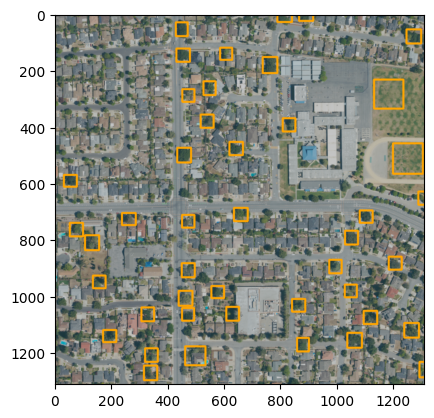

In [ ]:
model = main.deepforest()
model.use_release()

img = after.predict_image(path="TestingImageForPres.tiff",return_plot=True, color=(0, 165, 255), thickness=5)

#predict_image returns plot in BlueGreenRed (opencv style), but matplotlib likes RedGreenBlue, switch the channel order.
plt.imshow(img[:,:,::-1])

In [ ]:
#Reload the saved
after = main.deepforest.load_from_checkpoint("/content/drive/My Drive/deepForest/checkpoint")

Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:02<00:00, 68.0MB/s]


No validation file provided. Turning off validation loop


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
df = pd.DataFrame()

In [ ]:
count = 0
for filename in os.listdir("/content/drive/My Drive/18resampled/output"):
  img = after.predict_image(path="/content/drive/My Drive/18resampled/output/" + filename)
  #print(filename)
  df = df.append(img)
  count += 1
  print(count)


In [ ]:
df.to_csv("18predicted.csv", sep=',')
#df2 = pd.read_csv("temp.csv")

## 2. The following code blocks are responsible for fine tuning the pre-trained model using our labelled images. After this we save the model's fine tuned parameters for future use.

In [ ]:
# Prepare the model's training and validation files. This code also runs the fine tuning
# annotations_file = "/content/drive/My Drive/deepForest/combined.all.csv_"
annotations_file = "/content/drive/My Drive/deepForest/combined.train.final.csv"
validation_file = "/content/drive/My Drive/deepForest/combined.valid.final.csv"
df = pd.read_csv(annotations_file)

model = main.deepforest()
model.config["epochs"] = 1
model.config["save-snapshot"] = False
model.config["train"]["csv_file"] = annotations_file
model.config["train"]["root_dir"] = os.path.dirname(annotations_file)
model.config["validation"]["csv_file"] = validation_file
model.config["validation"]["root_dir"] = os.path.dirname(validation_file)
model.use_release()
model.create_trainer()
model.config["train"]["fast_dev_run"] = True
model.trainer.fit(model)

In [ ]:
#Save the model after the training process is complete
model.trainer.save_checkpoint("/content/drive/My Drive/deepForest/checkpoint")

## 3. I wrote the following code snippet in order to flip ymin, ymax and xmin, xmax when the values of the numbers were larger than other. The issue was caused due to the way some trees were labelled. This is a simple fix that cirumvents the issue.

In [ ]:
df = pd.read_csv("combined.valid.csv_")

In [ ]:
#Flip xmin with xmax if it's larger. And flip ymin with ymax if it's larger.
count = 0
images = set()
for index, row in df.iterrows():
  if row['xmax'] <= row['xmin']:
      temp = row['xmax']
      df.at[index, 'xmax'] = row['xmin']
      df.at[index, 'xmin'] = temp
      count += 1
      images.add(row["image_path"])
  if row['ymax'] <= row['ymin']:
      temp = row['ymax']
      df.at[index, 'ymax'] = row['ymin']
      df.at[index, 'ymin'] = temp

for i in images:
  print(i)

print(count)

In [ ]:
#Check to see if all entries have been fixed. Count should be 0
count = 0
images = set()
for index, row in df.iterrows():
  if row['xmax'] <= row['xmin']:
    count += 1
    images.add(row["image_path"])
print(count)
for i in images:
  print(i)

In [ ]:
df.to_csv("18predicted.csv", sep=',')
#df2 = pd.read_csv("temp.csv")

## 4. The following code blocks are responsible for evaluating our results. We focus on using DeepForest's box recall and box precision metrics.

In [ ]:
#Run DeepForest's Evaluation Method
results = model.evaluate(validation_file, os.path.dirname(validation_file), iou_threshold = 0.4)

In [ ]:
#Calculate the recall
results['box_recall']

0.3820262755206288

In [ ]:
#Calculate Precision
results['box_precision']

0.3552180795739125